<a href="https://colab.research.google.com/github/THUNDERSAMA/scripts/blob/main/explainable_ai_mnist_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

# Add this line to import the required function
from tensorflow.keras.backend import squeeze

In [ ]:



(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


x_train, x_test = x_train / 255.0, x_test / 255.0


model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


model.fit(x_train.reshape(-1, 28, 28, 1), y_train, epochs=3)






Epoch 1/3
1875/1875 [==============================] - 62s 32ms/step - loss: 0.1515 - accuracy: 0.9533
Epoch 2/3
1875/1875 [==============================] - 45s 24ms/step - loss: 0.0473 - accuracy: 0.9855
Epoch 3/3
1/1 [==============================] - 0s 78ms/step


In [ ]:


random_index = np.random.randint(0, len(x_test))
test_image = x_test[random_index]


input_image = test_image.reshape(1, 28, 28, 1)


prediction = model.predict(input_image)


predicted_label = np.argmax(prediction)

1/1 [==============================] - 0s 23ms/step


In [ ]:
last_conv_layer_name = ""
for layer in reversed(model.layers):
    if 'conv2d' in layer.name:
        last_conv_layer_name = layer.name
        break

last_conv_layer = model.get_layer(last_conv_layer_name)
grad_model = models.Model([model.inputs], [last_conv_layer.output, model.output])

with tf.GradientTape() as tape:
    conv_output, predictions = grad_model(input_image)
    loss = predictions[:, predicted_label]

grads = tape.gradient(loss, conv_output)[0]

pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

last_conv_output = conv_output[0]
last_conv_layer = model.get_layer(last_conv_layer_name)
print(last_conv_layer.input_shape)
heatmap = tf.multiply(last_conv_output, tf.reshape(pooled_grads, (1, 1, 1, -1)))
heatmap = tf.reduce_sum(heatmap, axis=-1)
print(heatmap.shape)


(None, 5, 5, 64)
(1, 3, 3)


In [ ]:
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

heatmap.get_shape().as_list()


[1, 3, 3]

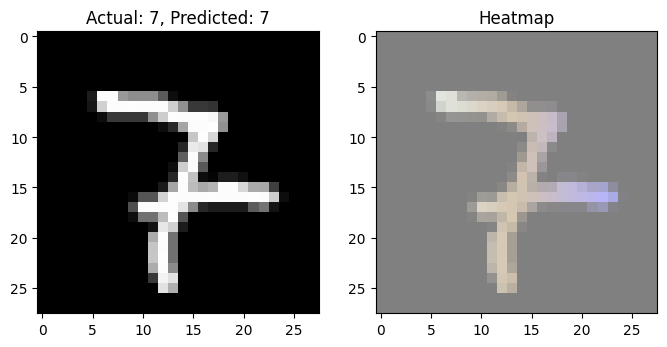

In [ ]:
if heatmap.ndim not in (3, 4):
    raise ValueError('\'heatmap\' must have either 3 or 4 dimensions.')


if heatmap.ndim == 3:
    heatmap = heatmap[np.newaxis, :, :, :]


heatmap = tf.image.resize(heatmap, (28, 28))


heatmapped_image = (heatmap * test_image[..., np.newaxis])


heatmapped_image = tf.squeeze(heatmapped_image)


fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(test_image, cmap='gray')
axes[0].set_title(f"Actual: {y_test[random_index]}, Predicted: {predicted_label}")
axes[1].imshow(heatmapped_image, cmap='jet', alpha=0.5)
axes[1].set_title("Heatmap")
plt.show()